# The used code and text are from the reference below, few modications have been done to it:

In [1]:
# ---------------------------------------------------------
# Title: Refugee Project Code
# Author: nikodemicek
# Date: 2022
# Code version: v1.0
# Availability: https://github.com/nikodemicek/refugee_project/tree/main/Code
# ---------------------------------------------------------


In [ ]:
from time import time
from collections import Counter, defaultdict
import re
import pandas as pd
import bs4 as soup
from bs4 import BeautifulSoup
from collections import Counter
import stanza
import numpy as np
import os
import re
from tqdm.auto import tqdm

# Pickle Implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# pickle functions for quick storage and loading of checkpoint files
import pickle

def pickle_file(file_name, file_to_dump):
    directory_path = "/content/drive/MyDrive/code_file/"
    file_path = os.path.join(directory_path, file_name)
    with open(file_path, 'wb') as fp:
        pickle.dump(file_to_dump, fp)

def load_pickle(file_name):
    directory_path = "/content/drive/MyDrive/code_file/"
    file_path = os.path.join(directory_path, file_name)
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)

# 1. Importing the data

Pre-requisite files:

- general_complete.csv - the full concatenated dataset that contains of 50% of articles about ukrainian refugees and 50% of syrian refugees

In [ ]:
def read_event_df(event_name):
    # reading the clean event dataframes based on the event name
    assert event_name in ['syria', 'ukraine', 'general']
    
    event_path = f"{event_name}_complete.csv"
    directory_path = '/content/drive/MyDrive/code_file/'+ event_path
    event_df = pd.read_csv(directory_path, index_col=0, encoding='ISO-8859-1')
    event_df.reset_index(drop=True, inplace=True)
    print(f'loaded {event_df.shape[0]} articles!')
    return event_df


In [ ]:
# pick the df 
event_df = read_event_df('general')
event_df.head()

loaded 27108 articles!


,Date,Headline,merged_text,id,parsing_corpus,frame_identification_corpus
0,2022-07-11,Scotland to pause Ukrainian refugee sponsorshi...,Scotland is to pause its Ukrainian refugee spo...,2022-07-11ScotlandtopauseUkrainianrefugeespons...,Scotland is to pause its Ukrainian refugee spo...,scotland pause ukrainian refugee sponsorship s...
1,2022-11-29,Ukrainian refugees and hosts petition UK gover...,Ukrainian refugees and their hosts have delive...,2022-11-29UkrainianrefugeesandhostspetitionUKg...,Ukrainian refugees and their hosts have delive...,ukrainian refugee host delivered petition down...
2,2022-11-27,Concern for health of Ukrainians aboard Scotla...,The physical and mental health of Ukrainian re...,2022-11-27ConcernforhealthofUkrainiansaboardSc...,The physical and mental health of Ukrainian re...,physical mental health ukrainian refugee livin...
3,2022-12-23,Ã¢ÂÂIÃ¢ÂÂm in a safe placeÃ¢ÂÂ: Ukrainia...,"Like many Ukrainian refugees, Yuliia Kashperen...",2022-12-23Ã¢ÂÂIÃ¢ÂÂminasafeplaceÃ¢ÂÂ:Ukr...,Like many Ukrainian refugees Yuliia Kashperenk...,like many ukrainian refugee yuliia kashperenko...
4,2022-05-05,The Ukrainian children at the mercy of UKÃ¢ÂÂ...,Nazarii has spent the last three weeks listeni...,2022-05-05TheUkrainianchildrenatthemercyofUKÃ¢...,Nazarii has spent the last three weeks listeni...,nazarii spent last three week listening fighte...


# 2. Entity extraction: Tag articles using stanza module to get NER and POS tags in articles

In [ ]:
#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ needed when running first time ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#
stanza.download("en")
stanza.install_corenlp()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Installing CoreNLP package into /root/stanza_corenlp


In [ ]:
# loading the pipeline
en_nlp = stanza.Pipeline("en",  
                         tokenize_pretokenized=False,
                         ner_batch_size=6096,
                         processors = "tokenize,pos,lemma,depparse,ner")

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| ner       | ontonotes |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
event_name = 'general'
event_df = read_event_df(event_name)
event_tagged_articles = [en_nlp(art_batch) for art_batch in tqdm(list(event_df['parsing_corpus']))]
pickle_file(f'{event_name}_tagged_articles',event_tagged_articles)


# 3. Entity alignment
## 3.1. Merging step 1


Pre-requisite files:

- event_tagged_articles = python object with tagged articles

The first merging step is an overlap between extraction and alignment. First, we extract the entities from the tagged articles objects. Next, we process them, remove the duplicates by counting their instances and store them in a data frame. The dataframe is sorted by frequency of the entities.

In [ ]:
from nltk import word_tokenize
from tqdm.auto import tqdm
def get_article_tags(tagged_articles):
    """
    Input: pre-tagged articles
    Output: list of lists containing named entities
    """
    article_entities=[]
    excluded_tags = ['CARDINAL', 'DATE', 'QUANTITY', 'TIME', 'PERCENT', 'MONEY', 'ORDINAL']
    for article in tqdm(range(len(tagged_articles))):
            article_ner= [ent.text for sent in tagged_articles[article].sentences for ent in sent.ents if ent.type not in excluded_tags]
            article_entities.append(article_ner)
    return article_entities  

def get_ent_head(entity):
    if len(word_tokenize(entity))>1:
        entity_doc = en_nlp(entity)
        #the root of NP has value 0. Since head is only one and stored in a list, we pick item [0]
        return [word.text for article_ent in entity_doc.sentences for word in article_ent.words if word.head == 0][0]
    else:
        return entity

def process_entity(entity):
    # re.sub removes all non alpanumeric characters (and lower() lowercases)
    # " ".join and split removes the consecutive whitespaces created by replacing characters
    entity = re.sub('[^0-9a-zA-Z]+', ' ', entity.lower())
    return " ".join(entity.split())

def create_entities_df(tagged_articles):
    event_entities = get_article_tags(tagged_articles)
    list_of_entities = [article_entities for article_entities in event_entities]
    entity_list = [process_entity(entity) for article in list_of_entities for entity in article]
    counted_entities = Counter(entity_list)
    ent_df = pd.DataFrame(counted_entities.items(), columns=['entity', 'freq']).sort_values('freq', ascending=False)
    ent_df = ent_df[ent_df.freq >= 5]
    ent_df['len'] = ent_df.entity.apply(lambda x: len(x))
    ent_df = ent_df[ent_df['len'] >= 2]
    ent_df['head'] = ''
    for i, row in tqdm(ent_df.iterrows(), total=ent_df.shape[0]):
        ent_df.at[i, 'head'] = get_ent_head(row['entity'])
    ent_df.reset_index(drop=True, inplace=True)
    return ent_df[['entity', 'freq', 'head']]



def merging_step1(event_name):
    print(f'loading {event_name} tagged articles...')
    tagged_articles = load_pickle(f'{event_name}_tagged_articles')
    ent_df = create_entities_df(tagged_articles)
    pickle_file(f'{event_name}_ents',ent_df)
    return ent_df

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
ent_df = merging_step1('general')


loading general tagged articles...


  0%|          | 0/27108 [00:00<?, ?it/s]

  0%|          | 0/31083 [00:00<?, ?it/s]

# 3.2. Merging step 2: Similarity using Sentence BERT embeddings
## 3.2.1. Encode entities with S-BERT embeddings


Pre-requisite files:

- event_ents = df with event entities after 1st merging step to be encoded

In [ ]:
def train_embeddings(event_ents):
    from time import time
    from sentence_transformers import SentenceTransformer
    #sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

    bert_corpus = list(event_ents['entity'])

    print(f'there are {len(bert_corpus)} entities to be encoded')
    t0 = time()
    ent_embeddings = sbert_model.encode(bert_corpus)
    print(f'Training embeddings took {time()-t0} seconds')
    return ent_embeddings

In [ ]:
event_ents = load_pickle('general_ents')

document_embeddings = train_embeddings(event_ents)

pickle_file('general_embeddings_ents', document_embeddings)

there are 31083 entities to be encoded
Training embeddings took 12.900951862335205 seconds


In [ ]:
print(load_pickle('general_embeddings_ents'))


[[-0.12737013  0.11356742  0.0079525  ... -0.03967512  0.03788215
  -0.14937823]
 [-0.05997204 -0.23132282  0.02037483 ... -0.06947303 -0.02981339
  -0.19086534]
 [-0.14561793 -0.01264451  0.01418668 ... -0.02158236  0.03191764
  -0.16745442]
 ...
 [-0.01442699 -0.14088528 -0.02071454 ...  0.07299806 -0.04206521
  -0.01368213]
 [-0.11453068  0.10514895 -0.07203719 ... -0.18027988  0.0109933
  -0.09981659]
 [ 0.00879196  0.03760856 -0.04121802 ... -0.02185031  0.04785962
  -0.14169759]]


# 3.2.2 Creating a similarity dataframe
The similarity dataframe enables faster lookup and experimentation with optimal thresholds when aligning entities 

Pre-requisite files:
- [event_name]_ents
- [event_name]_embeddings_ents

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def create_sim_df(event_name, sim_threshold=0.6):
    """
    1. loads necessary files for the selected event 
    2. calculates pairwise cosine similarity of the entity embeddings 
    3. stores the pairs and their similarity in the similarity dataframe"""
    event_entities = load_pickle(f'{event_name}_ents')
    ent_embeddings = load_pickle(f'{event_name}_embeddings_ents')
    rows_list = []
    
    #calculate pairwise similarities
    sims = cosine_similarity(ent_embeddings)
    
    # check whether a pair similarity is above the given threshold, store in the sim_df if true
    for up_ent_id in tqdm(range(len(event_entities))):
        for low_ent_id in range(len(event_entities)):
            dict1 = {}
            # get input row in dictionary format
            # key = col_name
            if sims[up_ent_id][low_ent_id]>sim_threshold:
                dict1.update({'text': event_entities['entity'][up_ent_id], 
                              'text_to_compare':event_entities['entity'][low_ent_id], 
                              'sim':sims[up_ent_id][low_ent_id]}) 
                rows_list.append(dict1)

    sim_df = pd.DataFrame(rows_list)
    return sim_df

In [ ]:
sim_df = create_sim_df('general')
pickle_file('general_sim_df_ents',sim_df)

  0%|          | 0/31083 [00:00<?, ?it/s]

In [ ]:
#sim_df enables lookup of the most similar terms 
sim_df = load_pickle('general_sim_df_ents')

#sim_df enables lookup of the most similar terms 
sim_df = load_pickle('general_sim_df_ents')
sim_df[sim_df.text=='Ukraine'].sort_values('sim',ascending=False)[:20]

sim_df

,text,text_to_compare,sim
0,ukraine,ukraine,1.000000
1,ukraine,russian,0.626658
2,ukraine,ukrainian,0.893672
3,ukraine,russia,0.711446
4,ukraine,russias,0.699616
...,...,...,...
1001454,eldaour,eloise,0.605663
1001455,eldaour,elviras,0.667965
1001456,eldaour,maroun elrass,0.654803
1001457,eldaour,ezadeens,0.603535


## 3.2.3. Aligning the entities


Pre-requisite files:

- sim_df = df with all similar entity pairs)
- entities = df of all entities (including dissimilar) with frequencies

In [ ]:
def flatten(list_of_mixed_types):
    # helper function to convert a list of mixed types (strings and lists) into a list
    flat_list = []
    for element in list_of_mixed_types:
        if isinstance(element,list): 
            flat_list.extend(flatten(element))
        else: 
            flat_list.append(element)
    return flat_list

def align_transitively(what_merged):
    """
    function to transitively merge the entities
    """
    merged_dict = defaultdict(list)
    merged_ent = set()
    
    for key,value in tqdm(what_merged.items()):
        merged_ent.update(what_merged[key])
        for item in value:
            merged_dict[key].extend(what_merged[key])
            if item in what_merged.keys() and item != 'russias':
                merged_dict[key].extend(what_merged[item])
                merged_dict[key] = list(set(merged_dict[key]))

        #print('-------loop------')
        for ent,merged in what_merged.items():
            for item2 in merged:
                if item2 in what_merged[key] and item2 in what_merged[ent] and key!=ent:
                    merged_dict[key].extend(what_merged[key] + what_merged[ent])
                    merged_dict[key].append(ent)
                    merged_ent.add(ent)
        merged_dict[key] = list(set(merged_dict[key]))  
        #merged_dict[key].pop(merged_dict[key].index(key))
    return merged_dict

def finalize_ents(merged_dict):
    final_ents = defaultdict()
    check_set = set()
    for key,value in merged_dict.items():
        if key not in check_set:
            final_ents[key] = merged_dict[key]
            check_set.update(merged_dict[key])
    
    for key in final_ents.keys():
        if key in final_ents[key]:
            final_ents[key].pop(final_ents[key].index(key))
    
    # add manual terms to the dict so (refugees and asyslum seekers) and (migrants and immigrants) are together
    final_ents['refugees'] = ['refugee', 'asylum seeker','internally displaced people', 'IDP']    
    return final_ents



def merging_step2(entities,sim_df,low_threshold=0.8, high_threshold =0.9, transitive=False): 
    """
    inputs:
    entities = entity df with entity frequencies
    sim_df = similarity dataframe with all pairs of entities that are at least [threshold] similar
    low_threshold = determines entity merge in the first merging round 
    high_threshold = determines entity merge in the second and subsequent merging rounds if transitive merge is enabled
    transitive = True if enabled
    returns:
    what_merged = dictionary with core entities as keys and lists of their merged entities as values
    """
    what_merged = defaultdict(list)
    merged_ents = set()

    #merge the dataframes so we have information about frequencies of entities in sim_df
    # use outer join to include the entities that are not similar to any other entity (thus not in sim_df)
    merged_df_ = pd.merge(sim_df,entities[entities.freq>=5], how='outer', left_on='text', right_on='entity')
    merged_df = pd.merge(merged_df_,entities[entities.freq>=5], how='outer', left_on='text_to_compare', right_on='entity')
    
    #blank fields in sim_df's text are the entities that are dissimilar to the rest, pass the value from entity text
    merged_df.entity_x.fillna(merged_df.entity_y, inplace=True) 
    merged_df.freq_x.fillna(merged_df.freq_y, inplace=True) 
    
    merged_df.drop(['text','text_to_compare'],axis=1,inplace=True)

    # and select only the rows above the lower threshold, so we do not have to filter by it in the loop
    merged_df_small = merged_df[merged_df.sim>low_threshold]

    print(f'finding merged entities...')
    # create an object to iterate over unique entities
    unique_merged_df = merged_df.groupby(by=['entity_x'], sort = False, as_index=False).agg({'freq_x':'max'}).sort_values('freq_x',ascending=False)

    def get_merged_entities(entity,transitive = False):
        """
        Store merged entities as list
        """
        lookup_df = pd.DataFrame({'entity_x': [], 'entity_y':[]})

        if entity not in merged_ents:
            if transitive == False:
                lookup_df = merged_df_small[merged_df_small.entity_x==entity]
                merged_ents.update(list(lookup_df['entity_y']))
            else:
                lookup_df = merged_df_small[(merged_df_small.entity_x==entity) & (merged_df_small.sim>high_threshold)]
        
        #clean nans 
        lookup_df = lookup_df[~lookup_df['entity_y'].isnull()]
        return list(lookup_df['entity_y'])
    
    tqdm.pandas() 
    #note that in the first round the transitiveness is False
    unique_merged_df['merged'] =  unique_merged_df.entity_x.progress_apply(get_merged_entities)

    #convert the dataframe into a dictionary
    for entity,merged_list in tqdm(zip(unique_merged_df['entity_x'],unique_merged_df['merged'])):
        what_merged[entity] = merged_list.copy()
        if transitive:
            for merged_ent in merged_list:
                what_merged[entity].append(get_merged_entities(merged_ent,transitive=True))
        what_merged[entity] = list(set(flatten(what_merged[entity]) ) ) 
    
    return what_merged

In [ ]:
def run_merging_step2(event_name,entity_type='ents',low_threshold=0.8, high_threshold = 0.9, transitive=True):
    sim_df = load_pickle(f'{event_name}_sim_df_{entity_type}')
    entities = load_pickle(f'{event_name}_{entity_type}')

    what_merged = merging_step2(entities,sim_df,high_threshold=high_threshold,transitive=transitive)
    
    if transitive:
        what_merged = align_transitively(what_merged)
            
    what_merged = finalize_ents(what_merged)
    
    pickle_file(f'{event_name}_what_merged',what_merged)
    return  what_merged 

In [ ]:
merged = load_pickle('general_sim_df_ents')


In [ ]:
merged[merged.text=="ukraine"]
merged

,text,text_to_compare,sim
0,ukraine,ukraine,1.000000
1,ukraine,russian,0.626658
2,ukraine,ukrainian,0.893672
3,ukraine,russia,0.711446
4,ukraine,russias,0.699616
...,...,...,...
1001454,eldaour,eloise,0.605663
1001455,eldaour,elviras,0.667965
1001456,eldaour,maroun elrass,0.654803
1001457,eldaour,ezadeens,0.603535


In [ ]:
merged_dict = run_merging_step2('general',low_threshold=0.7,high_threshold = 0.9, transitive=False)


finding merged entities...


  0%|          | 0/31083 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [ ]:
print(list(merged_dict.keys())[:20])


['ukraine', 'russian', 'us', 'syria', 'uk', 'europe', 'kyiv', 'un', 'poland', 'eu', 'israel', 'turkey', 'nato', 'putin', 'assad', 'iraq', 'moscow', 'mariupol', 'biden', 'germany']


In [ ]:
merged_dict['un']


['uns']

In [ ]:
sim_df[sim_df.text=='syria'].sort_values('sim',ascending=False)[:30]


,text,text_to_compare,sim
1967,syria,syria,1.000000
1972,syria,syrias,0.931801
2046,syria,syriaem,0.901224
1974,syria,syriaa,0.884626
1985,syria,syriah,0.877939
1968,syria,syrian,0.873278
1991,syria,syriabr,0.867589
2096,syria,syriathe,0.861635
2129,syria,syriaas,0.856219
2074,syria,syriana,0.848827


## 3.2.4. Find entity frequencies


Pre-requisite files:

- [event_name]_what_merged = dictionary of merged entities
- event_df = event dataset

This part serves solely for illustrative purposes of how much have been the counts of analyzable entities increased thanks to entity alignment.

In [ ]:
from collections import defaultdict
from itertools import combinations

def get_frequencies(what_merged, event_df):
    """
    in part 1: get frequencies of each item in what_merged dictionary from the corpus
    
    in part 2: correct frequencies for repeating terms
    """
    #~~~~ part 1 ~~~~
    freq_dict = defaultdict(list)
    event_df['parsing_corpus_lowercased'] = event_df['merged_text'].apply(lambda x: ' '.join(i.lower() for i in x.split()))
    for key in tqdm(what_merged.keys()):
        freq_dict2 = dict()
        c = sum(event_df['parsing_corpus_lowercased'].apply(lambda x: x.count(f' {key} ')))
        freq_dict[key].append(c)
        for item in what_merged[key]:
            c2 = sum(event_df['parsing_corpus_lowercased'].apply(lambda x: x.count(f' {item} ')))
            freq_dict2[item]=c2
        freq_dict[key].append(freq_dict2)
    
    #~~~~ part 2 ~~~~
    
    # Instantiate dict to store individual count for entity and merged count
    freq_counts = defaultdict(dict)
    
    # Iterate over entities
    for ent in freq_dict.keys():
        
        #print(f"Ent: {ent}")
        adj_freq = 0
        
        # Store number of occurences of root entity
        root_freq = freq_dict[ent][0]
        
        # Instantiate empty list where entities are stored that have already been counted
        roots = []
        
        # Integrate main entity into dict of merged entities
        ent_dict = freq_dict[ent][1]
        ent_dict[ent] = freq_dict[ent][0]
        
        # Iterate over merged entities based on their length (in term of tokens) in ascending order
        for merged_ent in sorted(ent_dict.keys(), key = len):
            #print(f"Merged Ent: {merged_ent}")
            
            # Create all possible sub-combinations of entity while keeping the order constant
            # For example: "Greece Turkey Border" yields Greece, Turkey, Border, Greece Turkey, Turkey Border, Greece Turkey Border
            merged_ent_list = merged_ent.split(" ")
            all_slices = [merged_ent_list[s:e] for s, e in combinations(range(len(merged_ent_list)+1), 2)]
            all_slices_strings = [" ".join(l) for l in all_slices]
            
            # Iterate over all entities that have already been counted
            for root in roots:
                
                # Check if any of the substring of current entity has already been counted, if yes don't count it again
                if root in all_slices:
                    #print(f"{merged_ent} was removed to prevent double count. {root} has already been counted")
                    break
            
            # If entity has not been counted, count it and add entity to counted entities
            else:
                roots.append([merged_ent])
                #print(roots)
                adj_freq += ent_dict[merged_ent]
                #print(f"Frequency incremented by {ent_dict[merged_ent]}")
        
        # Update frequency dict
        freq_counts[ent]["Root"] = root_freq
        freq_counts[ent]["Overall"] = adj_freq


    return freq_dict,freq_counts

In [ ]:
event_df = read_event_df('general')
what_merged = load_pickle('general_what_merged')

freq_dict,total_freq = get_frequencies(what_merged, event_df)

loaded 27108 articles!


  0%|          | 0/21482 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
print(list(total_freq.keys())[:30])


['uk', 'syria', 'turkey', 'greece', 'afghan', 'australian', 'the home office', 'unhcr', 'un', 'eu', 'russian', 'france', 'paris', 'asio', 'raad', 'braverman', 'sunak', 'lesbos', 'ukraine', 'mediterranean', 'bazzi', 'assad', 'europe', 'meloni', 'saviano', 'london', 'abdellatif', 'begum', 'spain', 'dutton']


In [ ]:
#total_freq


# Frame identification


In [ ]:
import os
import pandas as pd
import pickle
from sklearn.cluster import AffinityPropagation
from nltk.tokenize import word_tokenize,sent_tokenize
from time import time
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from collections import Counter
from time import time
import umap.umap_ as umap

In [ ]:
df_general = read_event_df('general')


loaded 27108 articles!


In [ ]:
general_ents = load_pickle('general_ents')


In [ ]:
df_general.head(2)

,Date,Headline,merged_text,id,parsing_corpus,frame_identification_corpus
0,2022-08-23,Turkeyâs rapprochement with Syria leaves reg...,Syrians across the opposition and in the Kurdi...,2022-08-23TurkeyâsrapprochementwithSyrialeav...,Syrians across the opposition and in the Kurdi...,syrian across opposition kurdish north country...
1,2023-01-20,US state department announces new refugee prog...,The US state department has announced a new re...,2023-01-20USstatedepartmentannouncesnewrefugee...,The US state department has announced a new re...,state department announced refugee program ord...


In [ ]:
# Manually remove entitiy similar words and non-framing related words

ne_list = "assad arab israel russia iran iraq damascus palestinian lebanon bashar israeli libya egypt trump obama american european britian british syrian syria turkey afgan greece turkish greek afghanistan ahmad asio meloni raad begum refugee asylum australia australian france paris migration immigration migrant afgan russian ukrainian europe nation northern nation mariupol ukraine putin kyiv poland moscow germany biden nato".split(" ")

non_framing = "tuesday wednesday former width school march prime talk isi datetimetzpm going among four meeting blocktime block publishedtime blockelements datablockcontributor datetimezpm timezonebsttime guimage datacanonicalurl imagecreditphotograph timezonegmttime show news think called sunday point dont least thing monday friday good look tweet hour medium long east capital south western southern english world london sign place span across three around left right centre aside near time block-time published-time richlink timezone blockquote updated updated-time twitter-tweet block-title video element-tweet thumbnail element-rich-link image gu-image element-image photograph figcaption block-elements figure element interactive scheme guardian today britain million february thursday day number december week many since year month much added well know every related already saying another used without like according quoted told even including part say could also would said next take coming back still come morning first last http head want find made make able claim small height arm clear found rich link deal others must however thousand mean later face spent decade held really cost expected rather despite september story never continue came become appeal spanrelated spana sunak country".split(" ")

removed_words = list(set(ne_list + non_framing))

len(removed_words)

228

In [ ]:
def get_most_frequent_words(df_col):
    
    all_words = list()
    
    for words in df_col:
        for word in words:
            all_words.append(word)
            
    counter = Counter(all_words)
    
    return [pair[0] for pair in counter.most_common(int(len(counter)*0.025))] #0.025

In [ ]:
def tokenization(df_col):
    """
    Takes a list with strings and returns a list with tokens
    """
    print("Tokenizing tweets...\n")
    return df_col.apply(lambda x: word_tokenize(x))

def remove_unfrequent_words(df_col):
    print("Removing unfrequent words...\n")
    most_frequent_words = get_most_frequent_words(df_col)
    print(f"(Removing words that are not among {len(most_frequent_words)} most frequent ones.)\n")
    return df_col.apply(lambda x: [token for token in x if token in most_frequent_words])

def remove_named_entities(df_col):
    print("Removing named entities...\n")
    return df_col.apply(lambda x: [token for token in x if token not in removed_words])

def preprocessing(df_col, *steps):
    """
    Takes in a dataframe column with text and applies preprocessing steps given 
    in and returns a string.
    
    Input:
    - df (dataframe): The dataframe containing the text column.
    - steps (functions): Multiple functions for preprocessing can be given in.
    
    Output:
    - List with strings.
    """
    # copying over the column for preprocessing
    temp = df_col.copy()
    for func in steps:
        temp = func(temp)
    return temp.apply(lambda x: " ".join([token for token in x]))

In [ ]:
df_general["text_frame_identification"] = preprocessing(df_general["frame_identification_corpus"],
                                                  tokenization,
                                                  remove_unfrequent_words,
                                                  remove_named_entities)

most_frequent_words = get_most_frequent_words(df_general["frame_identification_corpus"].apply(lambda x: word_tokenize(x)))
words_to_cluster_general = [word for word in most_frequent_words if word not in removed_words]


Tokenizing tweets...

Removing unfrequent words...

(Removing words that are not among 8705 most frequent ones.)

Removing named entities...



In [ ]:
len(words_to_cluster_general)


8498

In [ ]:
df_general.columns



Index(['Date', 'Headline', 'merged_text', 'id', 'parsing_corpus',
       'frame_identification_corpus', 'text_frame_identification'],
      dtype='object')

In [ ]:
df_general_frame = df_general[["merged_text","parsing_corpus","text_frame_identification","Date"]]


In [ ]:
df_general_frame.head(2)

,merged_text,parsing_corpus,text_frame_identification,Date
0,Scotland is to pause its Ukrainian refugee spo...,Scotland is to pause its Ukrainian refugee spo...,scotland pause sponsorship lack suitable accom...,2022-07-11
1,Ukrainian refugees and their hosts have delive...,Ukrainian refugees and their hosts have delive...,host delivered petition downing street signed ...,2022-11-29


# Train BERT


In [ ]:
from collections import Counter
def get_most_frequent_words(df_col):
    
    def clean_nes(article_words):
        return " ".join([word for word in article_words.split() if word not in removed_words])
    #tokenized_cols = df_col.apply(lambda x: word_tokenize(x) if len(x)>0 else x)
    df_col = df_col[~df_col.isnull()] 
    #df_col = df_col.apply(lambda x: print(x.split()) )
    #df_col = df_col.apply(clean_nes)
    #print(df_col)
    counter = Counter(" ".join(df_col).split())
    #print(counter.most_common(200))
    words = [pair[0] for pair in counter.most_common(200)]

    #words = [word for word in words if word not in removed_words]

    return words # list(set(words).difference(set(removed_words)))

def embed_words(words):
    from time import time
    from sentence_transformers import SentenceTransformer
    #sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

    #bert_corpus = list(words['entity'])

    print(f'there are {len(words)} entities to be encoded')
    t0 = time()
    word_embeddings = sbert_model.encode(words)
    print(f'Training embeddings took {time()-t0} seconds')
    return word_embeddings

In [ ]:
most_frequent_words_general = get_most_frequent_words(df_general["frame_identification_corpus"])
most_frequent_words_general = [word for word in most_frequent_words_general if word not in removed_words]
len(most_frequent_words_general)
#most_frequent_words_general


79

In [ ]:
def create_frames(embedding, preference, most_frequent_words):
    cluster = AffinityPropagation(preference = preference,  random_state=42).fit(embedding)
    cluster_labels = cluster.labels_
    
    labeled_article = pd.DataFrame({'word': most_frequent_words,'label':cluster_labels})
    
    # Create documents per label
    docs_per_class = labeled_article.groupby(['label'], as_index=False).agg({'word': ' '.join})

    words_per_class = dict()
    for label,word in zip(docs_per_class['label'],docs_per_class['word']):
        words_per_class[label] = word.split(' ')
    return pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in words_per_class.items() ])).fillna('.').head(50),words_per_class
    

In [ ]:
len(most_frequent_words_general)


79

In [ ]:
general_embeddings = embed_words(most_frequent_words_general)


there are 79 entities to be encoded
Training embeddings took 0.16144371032714844 seconds


In [ ]:
start = time()
reduced_embedding_general = umap.UMAP(random_state=42,
                                     n_components=3,
                                     min_dist=0.1,
                                     n_neighbors = 8).fit_transform(general_embeddings)
print(f'Duration: {time() - start} seconds')

Duration: 0.9491150379180908 seconds


In [ ]:
general_frame_df, general_frame_dict = create_frames(reduced_embedding_general,-17,most_frequent_words_general)


In [ ]:
#general_frame_dict

In [ ]:
# 0 - Political
# 1 - Displacement
# 2 - Humanitarian
# 3 - Violence 
general_frame_df

,0,1,2,3
0,government,city,people,force
1,president,state,child,military
2,minister,home,support,attack
3,official,border,family,security
4,leader,international,help,invasion
5,member,foreign,group,civilian
6,regime,united,need,killed
7,power,house,work,humanitarian
8,political,region,woman,weapon
9,service,area,report,troop


In [ ]:
pickle_file("general_frame_devices",general_frame_dict)


<ipython-input-189-8835ed25ea0e>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  seaborn.scatterplot(x = reduced_embedding_ukraine[:, 0],


<Axes: >

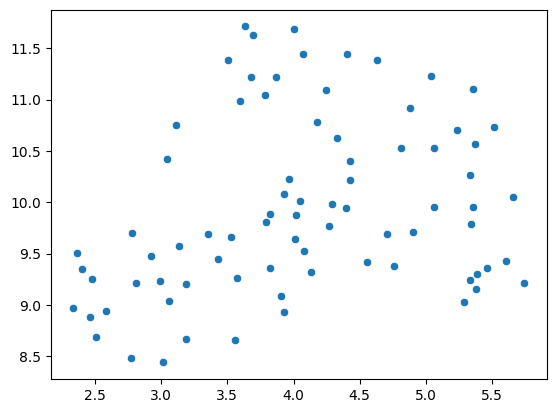

In [ ]:
import seaborn

seaborn.scatterplot(x = reduced_embedding_general[:, 0],
                y = reduced_embedding_general[:, 1], palette ="Paired")


In [ ]:
cluster = AffinityPropagation(preference = -17,  random_state=42).fit(reduced_embedding_general)
cluster_labels = cluster.labels_

<Axes: >

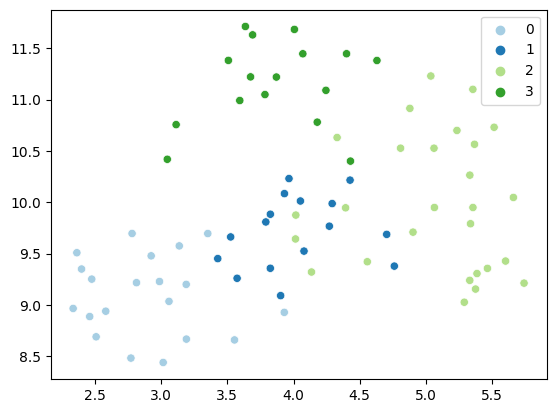

In [ ]:
import seaborn

seaborn.scatterplot(x = reduced_embedding_general[:, 0],
                y = reduced_embedding_general[:, 1],
                hue = cluster_labels, palette ="Paired")

# FRAME ATTRIBUTION
## In this section, frame properties are assigned to entities detected in the Entity identification section

1. Encoding the vocabulary of the event dataset
Pre-requisite files:

 -event_df = event dataset (specifically, frame identification corpus)

The word embeddings created in this step will be used to determine the similarity of words in the vocabulary to frames' seed words

In [ ]:
df_general = event_df

In [ ]:
from collections import defaultdict
import nltk
import os
import pickle
import stanza
import re
import pandas as pd
from  tqdm.notebook import tqdm


nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def get_bag_of_words(df_col):
    
    df_col = df_col[~df_col.isnull()] 
    df_col = df_col.apply(lambda x: x.split(' '))     
    bag_of_words = set([word for article_words in df_col for word in article_words if len(word)>1])

    return list(bag_of_words)


def embed_words(bag_of_words):
    from time import time
    from sentence_transformers import SentenceTransformer
    #sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

    print(f'there are {len(bag_of_words)} entities to be encoded')
    t0 = time()
    word_embeddings = sbert_model.encode(bag_of_words)
    print(f'Training embeddings took {time()-t0} seconds')
    return word_embeddings

In [ ]:
bow = get_bag_of_words(df_general["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('general_word_embeddings',model)

there are 348212 entities to be encoded
Training embeddings took 145.50316047668457 seconds


In [ ]:
frames = load_pickle('general_frame_devices')
print(frames)

{0: ['government', 'president', 'minister', 'official', 'leader', 'member', 'regime', 'power', 'political', 'service', 'policy', 'council', 'plan', 'sanction', 'agency', 'office', 'secretary', 'system', 'public', 'authority'], 1: ['city', 'state', 'home', 'border', 'international', 'foreign', 'united', 'house', 'region', 'area', 'national', 'community', 'local', 'west', 'town', 'peace'], 2: ['people', 'child', 'support', 'family', 'help', 'group', 'need', 'work', 'woman', 'report', 'life', 'crisis', 'conflict', 'call', 'human', 'party', 'food', 'action', 'issue', 'situation', 'opposition', 'statement', 'effort', 'change', 'company', 'supply', 'response'], 3: ['force', 'military', 'attack', 'security', 'invasion', 'civilian', 'killed', 'humanitarian', 'weapon', 'troop', 'fighting', 'police', 'camp', 'strike', 'missile', 'army']}


In [ ]:
frames['Political'] = frames.pop(0)
frames['Displacement'] = frames.pop(1)
frames['Humanitarian'] = frames.pop(2)
frames['Violence'] = frames.pop(3)




In [ ]:
pickle_file('general_final_frames',frames)


In [ ]:
en_nlp = stanza.Pipeline("en",  
                          tokenize_pretokenized=False,
                          processors = "tokenize,pos,lemma,depparse",
                          verbose=False)

In [ ]:
article = 'The ongoing conflict between Ukraine and Russia has resulted in a refugee crisis, with thousands of people fleeing their homes in eastern Ukraine. Russia has been accused of supporting separatists in the region and using the refugee crisis as a political tool.'
article = 'Millions of Syrian refugees have been displaced by the ongoing civil war in their country. Many have fled to neighboring countries, but they face numerous challenges in finding a new home and rebuilding their lives'
article = 'The international community has provided aid to help alleviate the suffering of Syrian refugees. This aid includes food, shelter, and medical assistance for those who have been displaced by the conflict'
article = 'Children who have been displaced by the conflict in Syria are at risk of experiencing violence and trauma. Many have witnessed the horrors of war and have been separated from their families, leading to long-term psychological damage'


doc = en_nlp(article)


In [ ]:
print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')


id: 1	word: Children       head id: 13   head: risk      deprel: nsubj
id: 2	word: who            head id: 5    head: displaced deprel: nsubj:pass
id: 3	word: have           head id: 5    head: displaced deprel: aux
id: 4	word: been           head id: 5    head: displaced deprel: aux:pass
id: 5	word: displaced      head id: 1    head: Children  deprel: acl:relcl
id: 6	word: by             head id: 8    head: conflict  deprel: case
id: 7	word: the            head id: 8    head: conflict  deprel: det
id: 8	word: conflict       head id: 5    head: displaced deprel: obl
id: 9	word: in             head id: 10   head: Syria     deprel: case
id: 10	word: Syria          head id: 8    head: conflict  deprel: nmod
id: 11	word: are            head id: 13   head: risk      deprel: cop
id: 12	word: at             head id: 13   head: risk      deprel: case
id: 13	word: risk           head id: 0    head: root      deprel: root
id: 14	word: of             head id: 15   head: experiencingdeprel: mark
i

In [ ]:
event_df = df_general

# 2. Assign frame properties to words in the corpus


Pre-requisite files:

 - event_df (or the bag_of_words file from the previous step)
 - model - embedded words for similarity comparison
 - frame_properties - dictionary of frames with seed words as values

The resulting word_properties file is a dictionary of all words in the event dataset and their similarity to the frame, calculated as the highest similarity out of all frame's seed words

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# run this if  [event]_word_properties does not exist yet
def assign_word_frame_properties(article_words,model,frame_properties):
    word_properties = defaultdict(dict)

    for word in tqdm(article_words):
        #print(word)
        word = lemma.lemmatize(word)
        property_list = []
        for prop in list(frame_properties.keys()):
            try:
                weights = [cosine_similarity(model[word].reshape(1,-1), model[seed].reshape(1,-1)) for seed in frame_properties[prop]]
                #print(weights)
                if max(weights)>0.7:
                    word_properties[word][prop] = max(weights)
                    #print(word,prop, max(weights))
            except KeyError:
                pass
    return  word_properties   

def get_word_properties(event_name):
    model = load_pickle(f'{event_name}_word_embeddings')
    frame_properties = load_pickle(f'{event_name}_final_frames')
    tqdm.pandas()
    word_properties = assign_word_frame_properties(get_bag_of_words(event_df['frame_identification_corpus']),model,frame_properties)
    pickle_file(f'{event_name}_word_properties', word_properties)
    return word_properties

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
word_properties = get_word_properties('general')


  0%|          | 0/348212 [00:00<?, ?it/s]

# 3. Assigning frames to entities


Pre-requisite files:

 - event_df = event dataset
 - [event]_tagged_articles = tagged articles object containing dependency parse trees
 - event_ents = list of event entities (we are going to use top 20 only)
 - frame_properties = dictionary of frames with seed words as values
 - word_properties = dictionary of all words in the event dataset and their similarity to frames

In [ ]:
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
def get_ent_head(entity):
    if len(word_tokenize(entity))>1:
        entity_doc = en_nlp(entity)
        #the root of NP has value 0. Since head is only one and stored in a list, we pick item [0]
        return [word.text for article_ent in entity_doc.sentences for word in article_ent.words if word.head == 0][0]
    else:
        return entity


en_nlp = stanza.Pipeline("en",  
                          tokenize_pretokenized=False,
                          processors = "tokenize,pos,lemma,depparse",
                          verbose=False)

In [ ]:
def assign_frame_properties(event_df, tagged_articles,event_ents,frame_properties,word_properties,event_name):
    # import these modules 
    from collections import defaultdict
    from nltk.stem import WordNetLemmatizer 
    import numpy as np
    
    def find_framed_words(ent_to_add, ent_to_compare,frame_properties,word_properties):
        #add frame by word choice 
        rep_head = get_ent_head(ent_to_compare)
        add_dataframe_entry(ent_to_add,rep_head,frame_properties,word_properties)
        #find all dependencies of the entity head
        for related in range(len(ent_words)):
            ent_word = ent_words[related][1].lower()
            if rep_head == ent_word:
                related_word = lemma.lemmatize(ent_words[related][2].lower())
                #add frame by labeling
                add_dataframe_entry(ent_to_add,related_word,frame_properties,word_properties) 
            elif rep_head == ent_words[related][2].lower() and ent_words[related][2].lower() in stop_words:
                add_dataframe_entry(ent_to_add,ent_word,frame_properties,word_properties) 
                
                
    
    def add_dataframe_entry(ent,framing_word,frame_properties,word_properties):
        #append a dataframe row with the entity and its assignment to a frame
        ent_frames['entity'].append(ent)
        ent_frames['framing_word'].append(framing_word)
        ent_frames['date'].append(event_df['Date'][article_id])
        ent_frames['article_id'].append(event_df['id'][article_id])
        
        for frame_property in list(frame_properties.keys()):
            
            #append the weight towards a frame to the entity row
            try:
                frame_weight = word_properties[framing_word][frame_property][0][0]
                ent_frames[frame_property].append(frame_weight)
                
            except KeyError:
                ent_frames[frame_property].append(np.NaN)
 
                        
    lemma = WordNetLemmatizer() 
    ent_frames = defaultdict(list)

    entities = list(event_ents.keys())[:20] + ['refugees']

    framed_words = pd.DataFrame(columns=['word','date','framing_word','article_id',list(frame_properties.keys())])
    
    # lowercase parsing corpus and remove extra whitespace so it is formatted in the same way as entities
    event_df['clean_parsing_corpus'] = event_df['parsing_corpus'].apply(lambda x: re.sub('[^0-9a-zA-Z]+', ' ', x.lower()))
    event_df['clean_parsing_corpus'] = event_df['clean_parsing_corpus'].apply(lambda x: " ".join(x.split()))
    
    for article_id in tqdm(event_df.index):
        clean_article = event_df['clean_parsing_corpus'][article_id]
        ent_words = [[word.id, word.text,sent.words[word.head-1].text] for sent in tagged_articles[article_id].sentences for word in sent.words]


        for ent in entities:
            #check if the entity is in the article
            if f' {ent} ' in f' {clean_article} ':
                loop_switch = False
                #if the entity is in the article, check if there is a merged entity that contains entity text
                for merged_ent in event_ents[ent]:
                    if f' {ent} ' in f' {merged_ent} ' and f' {merged_ent} ' in f' {clean_article} ':
                        # if trie, use merged_ent to find framed words. Since the list is sorted, loop is escaped once true
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        loop_switch=True
                        break
                    #elif f' {ent} ' in f' {clean_article} and f' {merged_ent} ' in f' {clean_article} ':
                # if there isn't a merged entity that contains entity text, use the main entity to find framed words    
                if loop_switch==False:
                    find_framed_words(ent,ent,frame_properties,word_properties)
            else:
                #if the main entity isn't in the article, look over its merged entities and add frames if it is contained
                for merged_ent in event_ents[ent]:
                    if f' {merged_ent} ' in f' {clean_article} ':
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        break
    
    return ent_frames

In [ ]:
def get_framed_entities(event_name):
    event_df = read_event_df(event_name)
    #event_df.reset_index(drop=False,inplace=True)
    tagged_articles = load_pickle(f'{event_name}_tagged_articles')
    event_ents = load_pickle(f'{event_name}_what_merged')
    frame_properties = load_pickle(f'{event_name}_final_frames')
    word_properties = load_pickle(f'{event_name}_word_properties')

    #sort the values in merged entities dictionary so the longest are first
    for key,value in event_ents.items():
        event_ents[key] = sorted(value,key=len, reverse=True)

    ent_frames = assign_frame_properties(event_df,tagged_articles,event_ents,frame_properties,word_properties,event_name)

    framed_entities = pd.DataFrame.from_dict(ent_frames)

    pickle_file(f'{event_name}_framed_entities',framed_entities)
    return framed_entities

In [ ]:
import nltk
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
framed_entities = get_framed_entities('general')


loaded 27108 articles!


  0%|          | 0/27108 [00:00<?, ?it/s]

# 4. Frame heatmaps - finding frames ratios for entities

Pre-requisite files:

- framed_entities = dataframe of all framing instances in an event dataset

In [ ]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def aggregate_frames(framed_entities):
    frame_copy = framed_entities.copy()
    aggr_frames = frame_copy.groupby(['entity'],as_index=True,sort=False).count()    
    aggr_frames.drop(['framing_word','date','article_id'],axis=1,inplace=True)
    aggr_frames = aggr_frames.T
    aggr_frames =  aggr_frames.groupby(aggr_frames.index)[aggr_frames.columns].first()

    aggr_frames_pct = aggr_frames / aggr_frames.sum()

    return aggr_frames, aggr_frames_pct

def frame_heatmap(aggr_frames,event_name):
    cols = sorted(list(aggr_frames.columns))
    cols.remove('refugees')
    aggr_frames = aggr_frames[['refugees'] + cols]
    aggr_frames = aggr_frames.T
    
    cbar_kws = {"shrink":.5, 'extend':'both'} 
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(aggr_frames, cmap='Blues',  fmt='g')
    loc, labels = plt.xticks()

    ax.set_xticklabels(labels, rotation=90)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.xaxis.set_ticks_position('top') 
    ax.set(ylabel=None)
    figure = ax.get_figure()    
   

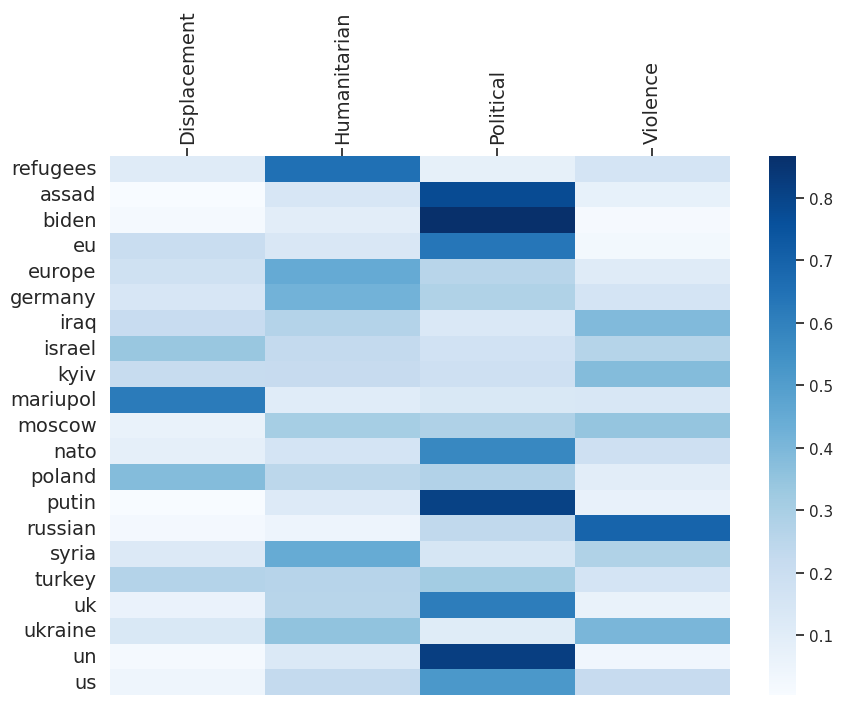

In [ ]:
framed_entities = load_pickle('general_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)

frame_heatmap(aggr_frames_pct,'general')